In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from shapely.geometry import Point
import shapely
pd.set_option('display.max_columns', None)


# Load Data

In [32]:
buildings_df = gpd.read_file('../data/Buildings/')
parcels_df = gpd.read_file('../data/Parcels_shape/')

# Find buildings in parcels

In [33]:
buildings_df_temp = buildings_df.copy()

In [34]:
buildings_df_temp.geometry = buildings_df_temp.geometry.centroid
buildings_df_temp = buildings_df_temp[buildings_df_temp.is_valid]
parcels_df = parcels_df[parcels_df.is_valid]

In [35]:
building_to_parcels = gpd.sjoin(
    buildings_df_temp[['OBJECTID','AddNum','Street','geometry']], 
    parcels_df[['MBL','geometry','AddNum','Street']], 
    how = 'inner', op = 'within'
)


In [36]:
buildings_parcels_df = (
    buildings_df
    .merge(building_to_parcels[['OBJECTID','MBL']])
    .merge(parcels_df, on = 'MBL')[['MBL', 'geometry_x', 'geometry_y','AddNum_y','Street_y']]
    .rename({'geometry_x':'building', 'geometry_y':'parcel'}, axis = 1)
)

In [37]:
buildings_parcels_df = buildings_parcels_df[buildings_parcels_df.parcel.apply(type) == shapely.geometry.polygon.Polygon]

In [38]:
buildings_parcels_df

,MBL,building,parcel,AddNum_y,Street_y
0,1-C-12,"POLYGON ((756465.867 2977205.199, 756545.334 2...","POLYGON ((756603.680 2977319.480, 756795.530 2...",600,MYSTIC VALLEY PKWY
1,1-C-10,"POLYGON ((756357.546 2977065.249, 756376.688 2...","POLYGON ((756440.270 2977039.480, 756376.730 2...",164-166,BOSTON AVE
2,1-C-3,"POLYGON ((756691.951 2976976.663, 756762.243 2...","POLYGON ((756832.498 2976978.882, 756765.916 2...",196,BOSTON AVE
3,2-A-2,"POLYGON ((756133.562 2976742.945, 756130.951 2...","POLYGON ((756167.150 2976757.586, 756142.680 2...",509-511,MYSTIC VALLEY PKWY
4,1-E-7,"POLYGON ((756454.407 2976736.201, 756484.109 2...","POLYGON ((756518.530 2976760.000, 756470.100 2...",179-181,BOSTON AVE
...,...,...,...,...,...
17026,42-C-4,"POLYGON ((762416.412 2967786.541, 762434.997 2...","POLYGON ((762449.349 2967788.510, 762414.920 2...",80,ALBION ST
17027,42-C-3,"POLYGON ((762393.088 2967758.749, 762387.361 2...","POLYGON ((762418.009 2967804.080, 762382.810 2...",82,ALBION ST
17028,42-C-2,"POLYGON ((762377.737 2967805.139, 762359.785 2...","POLYGON ((762386.669 2967819.650, 762349.050 2...",84,ALBION ST
17029,42-C-1,"POLYGON ((762312.214 2967807.996, 762304.099 2...","POLYGON ((762298.570 2967863.425, 762355.319 2...",88,ALBION ST


# Create Features


1. distance to each edge
2. buildings per parcel
3. number of edges in building footprint

### distance to each edge

In [9]:
row = buildings_parcels_df.loc[0]

In [10]:
def get_parcel_edge_midpoints(parcel):
    # simplify parcel so their are 4 coordinates
    tolerance_low = 0
    tolerance_high = 1e10
    num_coord = 0
        
    while True:
        tolerance = (tolerance_low + tolerance_high)/2
        parcel_simple = parcel.simplify(tolerance)
        try:
            parcel_corners = parcel_simple.boundary.coords
        except:
            return np.NaN
        num_coord = len(parcel_corners)
        if num_coord == 5 or tolerance_high - tolerance_low < 1e-10:
            break
        elif num_coord < 5:
            tolerance_high = tolerance
        else:
            tolerance_low = tolerance
    
    if num_coord == 4:
        parcel_corners = list(parcel_corners)
        parcel_corners.append(parcel_corners[1])

    # get midpoints of parcel edges
    midpoints = []
    for i in range(4):
        corner1 = np.array(parcel_corners[i])
        corner2 = np.array(parcel_corners[i+1])
        midpoints.append(Point((corner1 + corner2)/2))

    # get orientation
    if midpoints[0].distance(midpoints[2]) > midpoints[1].distance(midpoints[3]):
        midpoint_dict = {
            'side1': midpoints[1],
            'side2': midpoints[3],
            'front1': midpoints[0],
            'front2': midpoints[2]
        }
    else:
         midpoint_dict = {
            'side1': midpoints[0],
            'side2': midpoints[2],
            'front1': midpoints[1],
            'front2': midpoints[3]
        }
    return midpoint_dict

In [11]:
buildings_parcels_df['midpoints'] = buildings_parcels_df.parcel.apply(get_parcel_edge_midpoints)

buildings_parcels_df = buildings_parcels_df[~buildings_parcels_df.midpoints.isna()]

In [12]:
for clm in ['side1','side2','front1','front2']:
    buildings_parcels_df[clm + '_dist'] = buildings_parcels_df.apply(
        lambda row: row.building.distance(row.midpoints[clm]), axis = 1)

/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
buildings_parcels_df['side_diff'] = np.absolute(buildings_parcels_df.side1_dist - buildings_parcels_df.side2_dist)
buildings_parcels_df['front_diff'] = np.absolute(buildings_parcels_df.front1_dist - buildings_parcels_df.front2_dist)

/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
buildings_parcels_df

,MBL,building,parcel,AddNum_y,Street_y,midpoints,side1_dist,side2_dist,front1_dist,front2_dist,side_diff,front_diff
0,1-C-12,"POLYGON ((756465.867 2977205.199, 756545.334 2...","POLYGON ((756603.680 2977319.480, 756795.530 2...",600,MYSTIC VALLEY PKWY,{'side1': POINT (756699.6049687192 2977214.914...,16.988603,75.808057,12.863806,6.483753,58.819454,6.380053
1,1-C-10,"POLYGON ((756357.546 2977065.249, 756376.688 2...","POLYGON ((756440.270 2977039.480, 756376.730 2...",164-166,BOSTON AVE,{'side1': POINT (756335.085028477 2977010.9099...,1.912150,37.821137,29.678192,40.772160,35.908987,11.093969
2,1-C-3,"POLYGON ((756691.951 2976976.663, 756762.243 2...","POLYGON ((756832.498 2976978.882, 756765.916 2...",196,BOSTON AVE,{'side1': POINT (756774.0826740935 2976887.592...,0.000000,25.155006,53.853405,52.905400,25.155006,0.948005
3,2-A-2,"POLYGON ((756133.562 2976742.945, 756130.951 2...","POLYGON ((756167.150 2976757.586, 756142.680 2...",509-511,MYSTIC VALLEY PKWY,{'side1': POINT (756104.1435612217 2976747.035...,7.717136,0.000000,4.244006,17.169871,7.717136,12.925865
4,1-E-7,"POLYGON ((756454.407 2976736.201, 756484.109 2...","POLYGON ((756518.530 2976760.000, 756470.100 2...",179-181,BOSTON AVE,{'side1': POINT (756494.3148609251 2976725.320...,11.834419,1.014366,23.242898,4.667141,10.820053,18.575757
...,...,...,...,...,...,...,...,...,...,...,...,...
17026,42-C-4,"POLYGON ((762416.412 2967786.541, 762434.997 2...","POLYGON ((762449.349 2967788.510, 762414.920 2...",80,ALBION ST,{'side1': POINT (762432.1345141381 2967750.500...,0.497864,4.875995,27.915522,16.103476,4.378131,11.812045
17027,42-C-3,"POLYGON ((762393.088 2967758.749, 762387.361 2...","POLYGON ((762418.009 2967804.080, 762382.810 2...",82,ALBION ST,{'side1': POINT (762399.4844810143 2967763.190...,1.764885,4.032182,29.884433,14.263687,2.267297,15.620747
17028,42-C-2,"POLYGON ((762377.737 2967805.139, 762359.785 2...","POLYGON ((762386.669 2967819.650, 762349.050 2...",84,ALBION ST,{'side1': POINT (762367.8595442623 2967778.155...,2.174198,5.039889,26.716520,17.512531,2.865690,9.203989
17029,42-C-1,"POLYGON ((762312.214 2967807.996, 762304.099 2...","POLYGON ((762298.570 2967863.425, 762355.319 2...",88,ALBION ST,{'side1': POINT (762339.0244641379 2967799.275...,24.423804,3.278089,8.862547,16.812898,21.145714,7.950351


### buildings per parcel

In [15]:
building_per_parcels = gpd.sjoin(
    buildings_df_temp[['OBJECTID','AddNum','Street','geometry']], 
    parcels_df[['MBL','geometry','AddNum','Street']], 
    how = 'right', op = 'within'
)

In [16]:
building_per_parcels = building_per_parcels.groupby('MBL').size().reset_index().rename({0:'building_count'}, axis=1)

In [17]:
buildings_parcels_df = buildings_parcels_df.merge(building_per_parcels, how = 'left')

In [18]:
buildings_parcels_df

,MBL,building,parcel,AddNum_y,Street_y,midpoints,side1_dist,side2_dist,front1_dist,front2_dist,side_diff,front_diff,building_count
0,1-C-12,"POLYGON ((756465.867 2977205.199, 756545.334 2...","POLYGON ((756603.680 2977319.480, 756795.530 2...",600,MYSTIC VALLEY PKWY,{'side1': POINT (756699.6049687192 2977214.914...,16.988603,75.808057,12.863806,6.483753,58.819454,6.380053,1.0
1,1-C-10,"POLYGON ((756357.546 2977065.249, 756376.688 2...","POLYGON ((756440.270 2977039.480, 756376.730 2...",164-166,BOSTON AVE,{'side1': POINT (756335.085028477 2977010.9099...,1.912150,37.821137,29.678192,40.772160,35.908987,11.093969,1.0
2,1-C-3,"POLYGON ((756691.951 2976976.663, 756762.243 2...","POLYGON ((756832.498 2976978.882, 756765.916 2...",196,BOSTON AVE,{'side1': POINT (756774.0826740935 2976887.592...,0.000000,25.155006,53.853405,52.905400,25.155006,0.948005,1.0
3,2-A-2,"POLYGON ((756133.562 2976742.945, 756130.951 2...","POLYGON ((756167.150 2976757.586, 756142.680 2...",509-511,MYSTIC VALLEY PKWY,{'side1': POINT (756104.1435612217 2976747.035...,7.717136,0.000000,4.244006,17.169871,7.717136,12.925865,1.0
4,1-E-7,"POLYGON ((756454.407 2976736.201, 756484.109 2...","POLYGON ((756518.530 2976760.000, 756470.100 2...",179-181,BOSTON AVE,{'side1': POINT (756494.3148609251 2976725.320...,11.834419,1.014366,23.242898,4.667141,10.820053,18.575757,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16982,42-C-4,"POLYGON ((762416.412 2967786.541, 762434.997 2...","POLYGON ((762449.349 2967788.510, 762414.920 2...",80,ALBION ST,{'side1': POINT (762432.1345141381 2967750.500...,0.497864,4.875995,27.915522,16.103476,4.378131,11.812045,1.0
16983,42-C-3,"POLYGON ((762393.088 2967758.749, 762387.361 2...","POLYGON ((762418.009 2967804.080, 762382.810 2...",82,ALBION ST,{'side1': POINT (762399.4844810143 2967763.190...,1.764885,4.032182,29.884433,14.263687,2.267297,15.620747,1.0
16984,42-C-2,"POLYGON ((762377.737 2967805.139, 762359.785 2...","POLYGON ((762386.669 2967819.650, 762349.050 2...",84,ALBION ST,{'side1': POINT (762367.8595442623 2967778.155...,2.174198,5.039889,26.716520,17.512531,2.865690,9.203989,1.0
16985,42-C-1,"POLYGON ((762312.214 2967807.996, 762304.099 2...","POLYGON ((762298.570 2967863.425, 762355.319 2...",88,ALBION ST,{'side1': POINT (762339.0244641379 2967799.275...,24.423804,3.278089,8.862547,16.812898,21.145714,7.950351,1.0


## number of edges in building footprint

In [19]:
def get_edge_count(polygon):
    try:
        return len(polygon.boundary.coords)
    except NotImplementedError:
        return np.NaN
buildings_parcels_df['building_edges'] = buildings_parcels_df.building.apply(get_edge_count)
buildings_parcels_df['parcel_edges'] = buildings_parcels_df.parcel.apply(get_edge_count)

In [20]:
buildings_parcels_df

,MBL,building,parcel,AddNum_y,Street_y,midpoints,side1_dist,side2_dist,front1_dist,front2_dist,side_diff,front_diff,building_count,building_edges,parcel_edges
0,1-C-12,"POLYGON ((756465.867 2977205.199, 756545.334 2...","POLYGON ((756603.680 2977319.480, 756795.530 2...",600,MYSTIC VALLEY PKWY,{'side1': POINT (756699.6049687192 2977214.914...,16.988603,75.808057,12.863806,6.483753,58.819454,6.380053,1.0,15.0,11
1,1-C-10,"POLYGON ((756357.546 2977065.249, 756376.688 2...","POLYGON ((756440.270 2977039.480, 756376.730 2...",164-166,BOSTON AVE,{'side1': POINT (756335.085028477 2977010.9099...,1.912150,37.821137,29.678192,40.772160,35.908987,11.093969,1.0,18.0,30
2,1-C-3,"POLYGON ((756691.951 2976976.663, 756762.243 2...","POLYGON ((756832.498 2976978.882, 756765.916 2...",196,BOSTON AVE,{'side1': POINT (756774.0826740935 2976887.592...,0.000000,25.155006,53.853405,52.905400,25.155006,0.948005,1.0,28.0,12
3,2-A-2,"POLYGON ((756133.562 2976742.945, 756130.951 2...","POLYGON ((756167.150 2976757.586, 756142.680 2...",509-511,MYSTIC VALLEY PKWY,{'side1': POINT (756104.1435612217 2976747.035...,7.717136,0.000000,4.244006,17.169871,7.717136,12.925865,1.0,28.0,25
4,1-E-7,"POLYGON ((756454.407 2976736.201, 756484.109 2...","POLYGON ((756518.530 2976760.000, 756470.100 2...",179-181,BOSTON AVE,{'side1': POINT (756494.3148609251 2976725.320...,11.834419,1.014366,23.242898,4.667141,10.820053,18.575757,1.0,13.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16982,42-C-4,"POLYGON ((762416.412 2967786.541, 762434.997 2...","POLYGON ((762449.349 2967788.510, 762414.920 2...",80,ALBION ST,{'side1': POINT (762432.1345141381 2967750.500...,0.497864,4.875995,27.915522,16.103476,4.378131,11.812045,1.0,16.0,5
16983,42-C-3,"POLYGON ((762393.088 2967758.749, 762387.361 2...","POLYGON ((762418.009 2967804.080, 762382.810 2...",82,ALBION ST,{'side1': POINT (762399.4844810143 2967763.190...,1.764885,4.032182,29.884433,14.263687,2.267297,15.620747,1.0,17.0,6
16984,42-C-2,"POLYGON ((762377.737 2967805.139, 762359.785 2...","POLYGON ((762386.669 2967819.650, 762349.050 2...",84,ALBION ST,{'side1': POINT (762367.8595442623 2967778.155...,2.174198,5.039889,26.716520,17.512531,2.865690,9.203989,1.0,8.0,6
16985,42-C-1,"POLYGON ((762312.214 2967807.996, 762304.099 2...","POLYGON ((762298.570 2967863.425, 762355.319 2...",88,ALBION ST,{'side1': POINT (762339.0244641379 2967799.275...,24.423804,3.278089,8.862547,16.812898,21.145714,7.950351,1.0,21.0,8


## save

In [21]:
buildings_parcels_df = buildings_parcels_df[[
    'MBL',
    'side1_dist',
    'side2_dist',
    'front1_dist',
    'front2_dist',
    'side_diff',
    'front_diff',
    'building_count',
    'building_edges',
    'parcel_edges'
]]


In [26]:
buildings_parcels_df.groupby('MBL').min()

,side1_dist,side2_dist,front1_dist,front2_dist,side_diff,front_diff,building_count,building_edges,parcel_edges
MBL,,,,,,,,,
1-B-2,3.933567,0.000000,2.291777,1.408214,3.933567,0.883562,1.0,11.0,7
1-C-10,1.912150,37.821137,29.678192,40.772160,35.908987,11.093969,1.0,18.0,30
1-C-12,16.988603,75.808057,12.863806,6.483753,58.819454,6.380053,1.0,15.0,11
1-C-3,0.000000,25.155006,53.853405,52.905400,25.155006,0.948005,1.0,28.0,12
1-C-5,18.152800,19.224856,6.353409,22.946834,1.072056,28.307283,3.0,5.0,7
...,...,...,...,...,...,...,...,...,...
97-I-7,42.690646,0.233883,1.049178,0.000000,42.456763,1.049178,1.0,11.0,10
98-A-1,281.823931,121.890868,659.265802,321.649207,100.854025,185.406773,3.0,5.0,139
99-A-15,70.193226,13.341653,144.524044,35.194529,29.929549,20.341190,2.0,5.0,34


In [28]:
buildings_parcels_df.to_csv('../data/building_parcel_geometric_features.csv')

## Figures for Poster

In [70]:
from matplotlib import pyplot as plt
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

In [82]:
row = buildings_parcels_df[buildings_parcels_df.MBL == '73-B-6'].iloc[0]
row

MBL                                                    73-B-6
building    POLYGON ((765509.9082142264 2964440.109106809,...
parcel      POLYGON ((765544.9888527244 2964422.390310228,...
AddNum_y                                                   68
Street_y                                         COLUMBUS AVE
Name: 13374, dtype: object

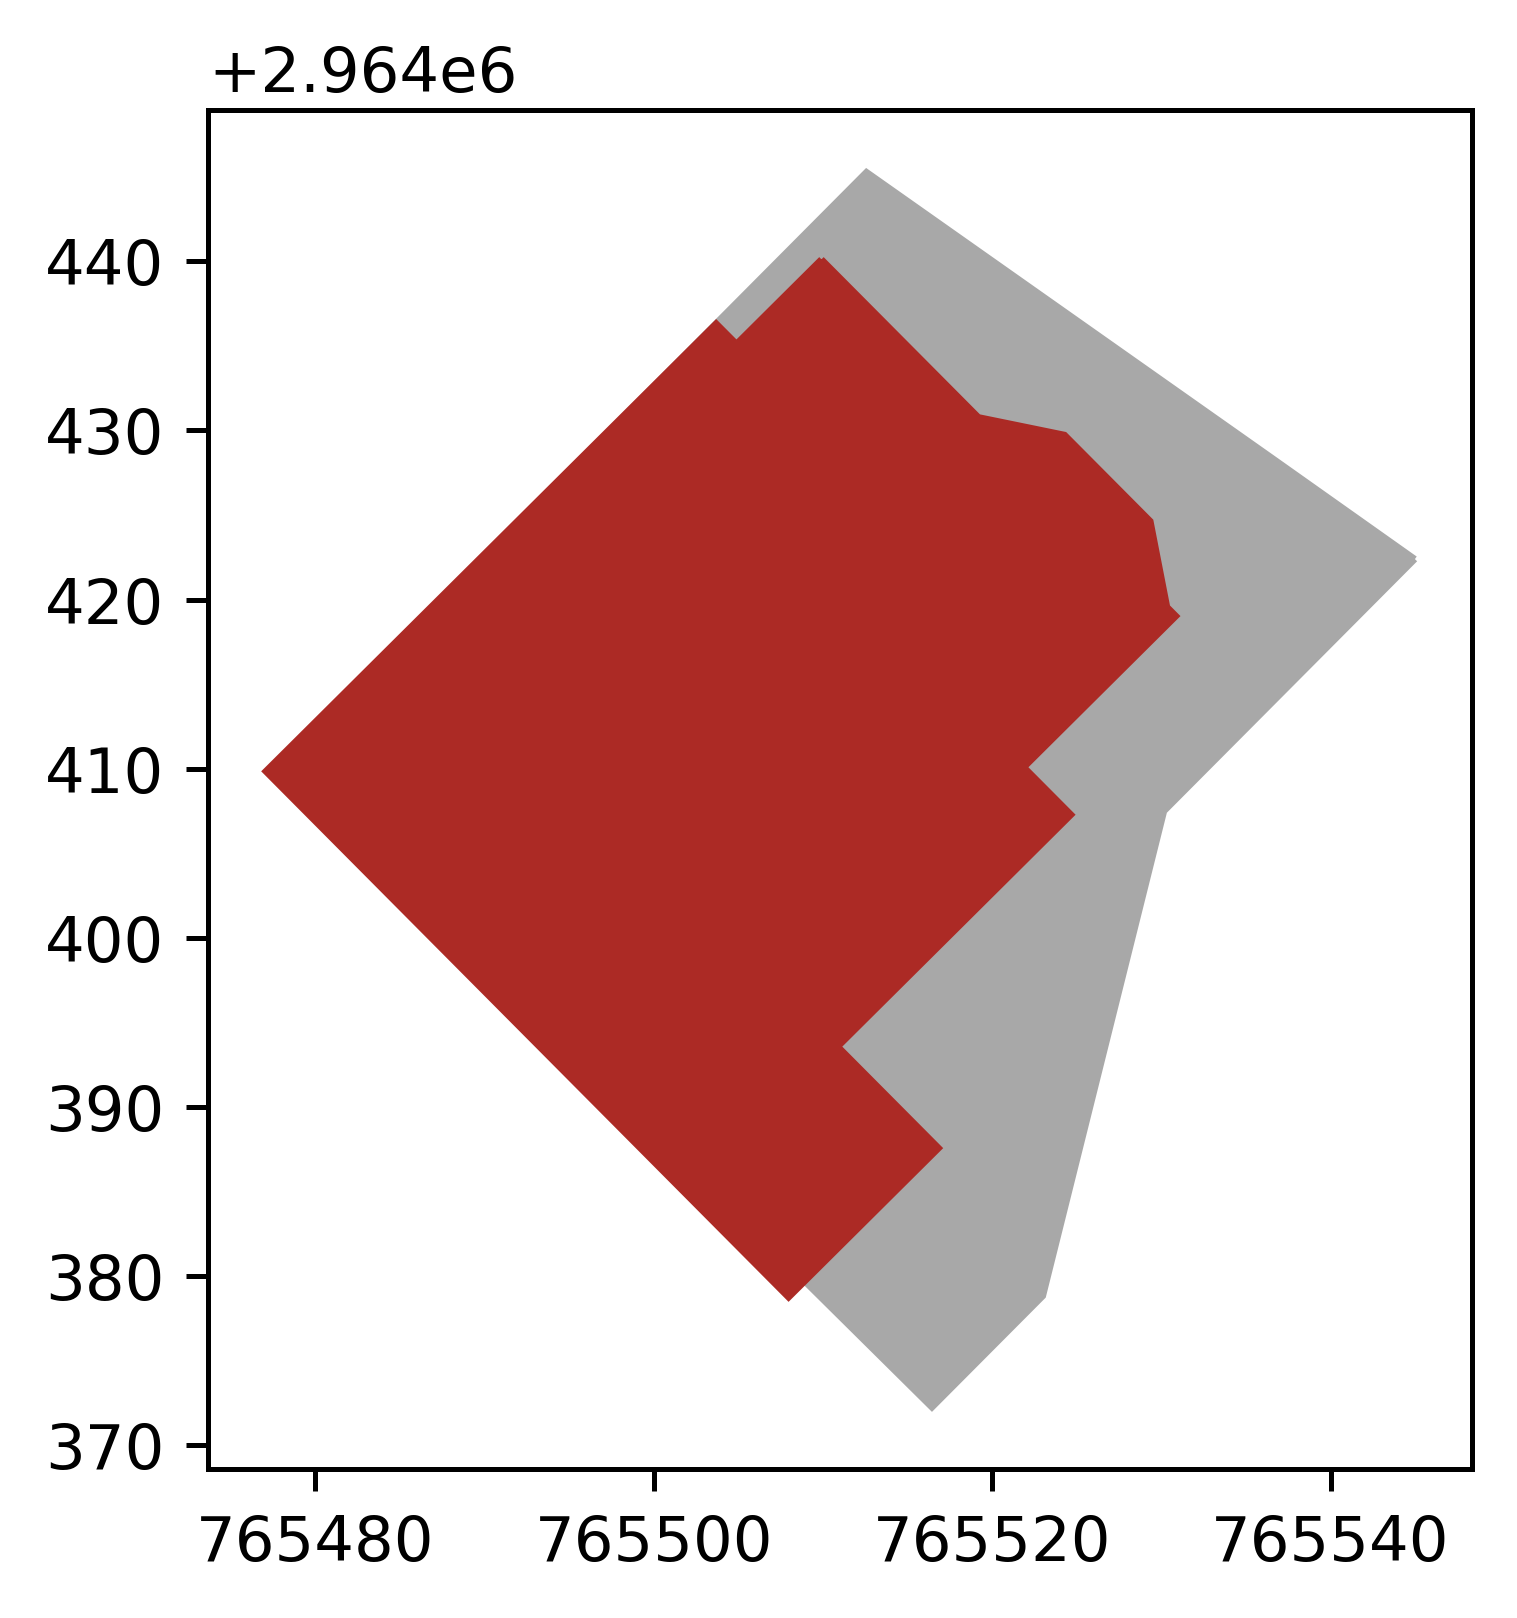

In [102]:
GREY = '#A8A8A8'
RED = '#AC2A25'
pavlos = row.building
pavlos_parcel = row.parcel

fig = plt.figure(dpi = 450) 
ax = fig.gca() 
ax.add_patch(PolygonPatch(pavlos_parcel, fc=GREY, ec=GREY, alpha=1, zorder=2 ))
ax.add_patch(PolygonPatch(pavlos, fc=RED, ec=RED, alpha=1, zorder=2 ))

ax.axis('scaled')
plt.savefig('../figures/pavlos.jpg')

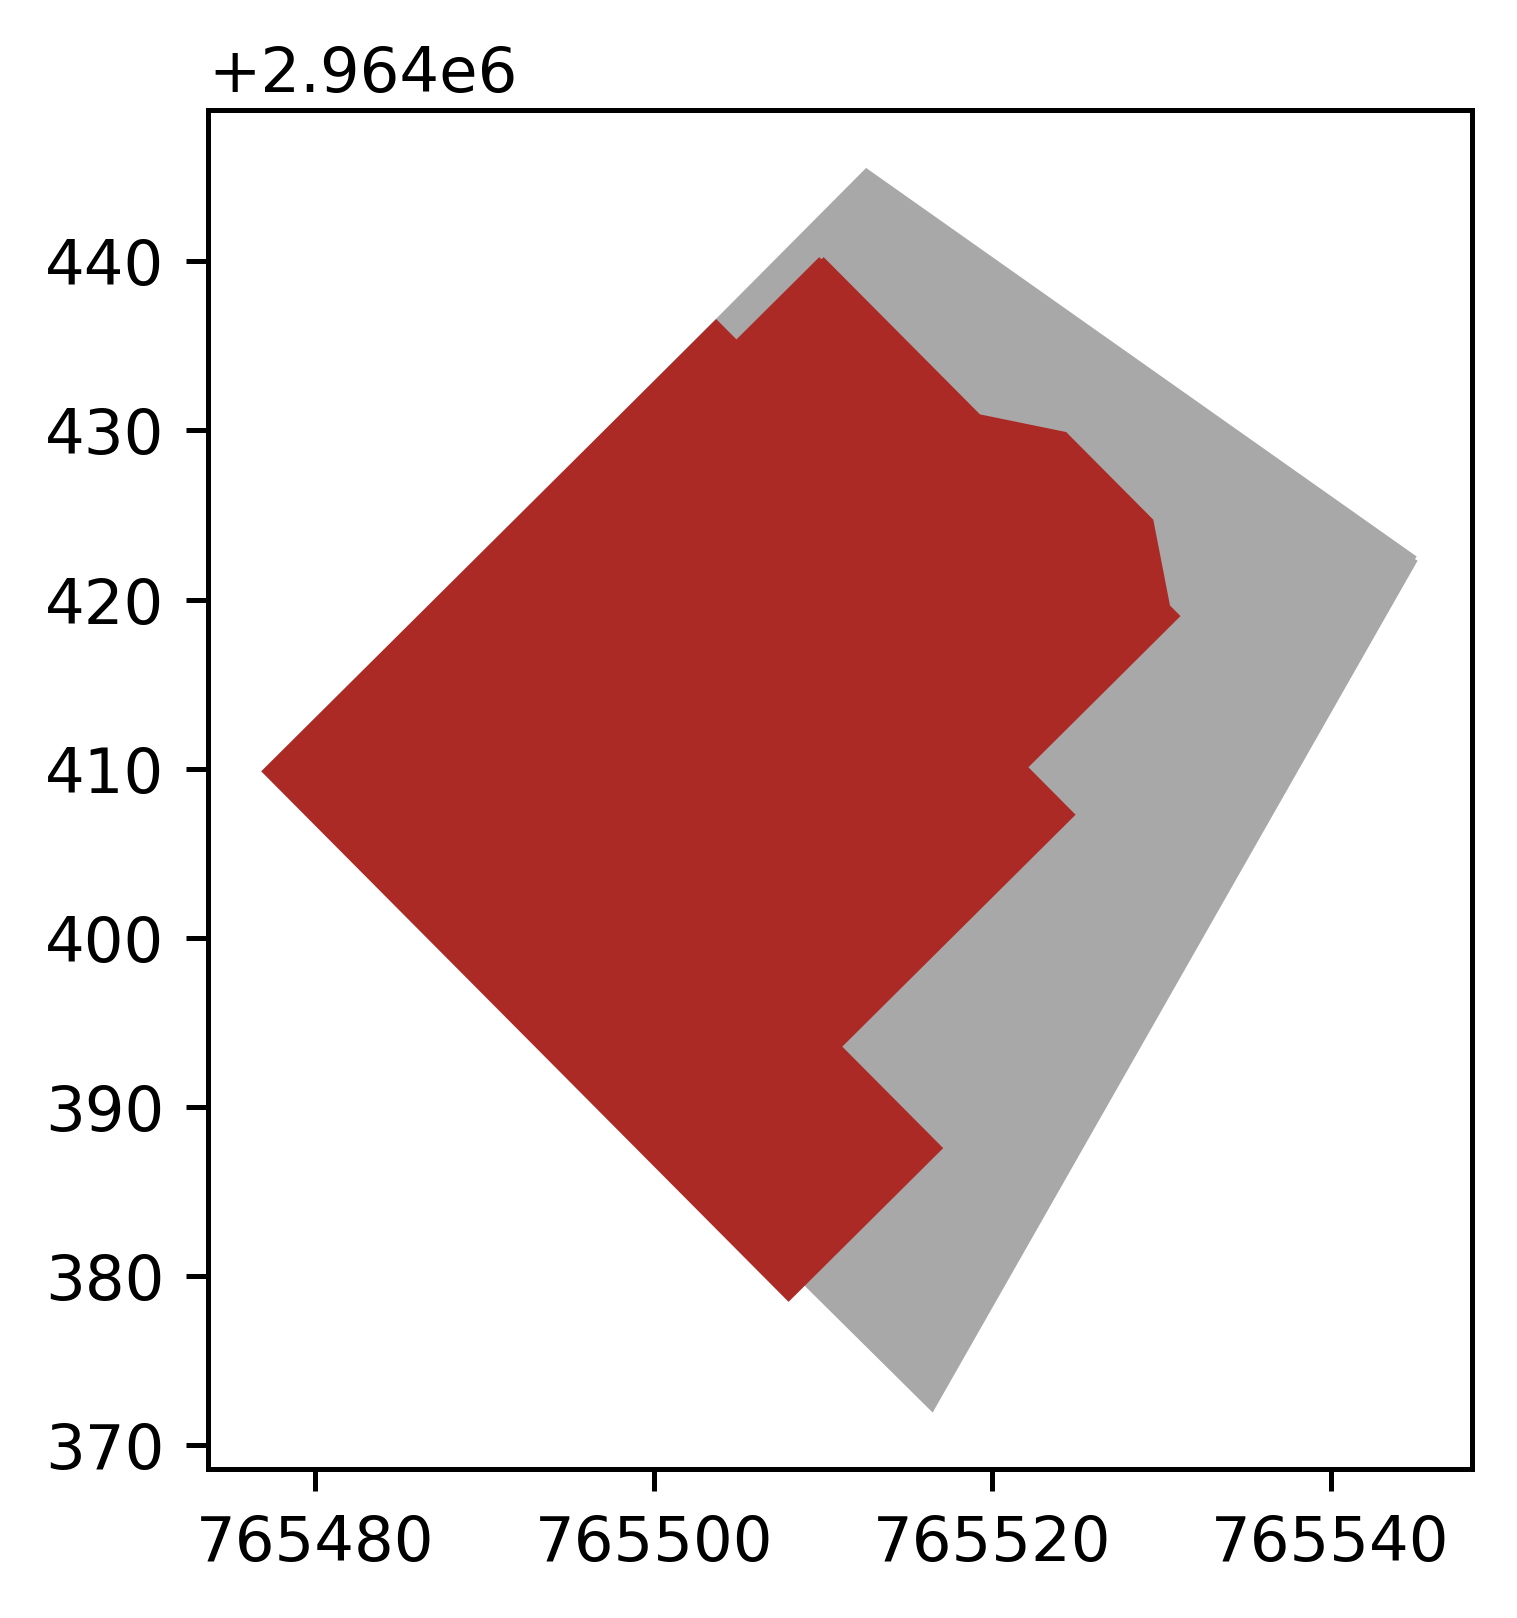

In [103]:
pavlos = row.building
pavlos_parcel = row.parcel.simplify(100)

fig = plt.figure(dpi = 450) 
ax = fig.gca() 
ax.add_patch(PolygonPatch(pavlos_parcel, fc=GREY, ec=GREY, alpha=1, zorder=2))
ax.add_patch(PolygonPatch(pavlos, fc=RED, ec=RED, alpha=1, zorder=2 ))

ax.axis('scaled')
plt.savefig('../figures/pavlos_simple.jpg')